# NOTEBOOK ON MASS-SPRING EXAMPLE USING THE R-PACKAGE `dlm`

by Sebastian T. Glavind, February 2022

In [1]:
# r code
# load package
library("dlm")

# Introduction

This notebook solves Example 2 from my tutorial [Linear Gaussian state space models and Kalman filters](https://nbviewer.jupyter.org/github/SebastianGlavind/Probabilistic_modeling_and_analysis/blob/main/State-space-models/SSMs_linearGaussian_Ex_MassSpringSys.ipynb) using the R package [`dlm`](https://cran.r-project.org/web/packages/dlm/index.html) which is the supporting software package for Petris et al (2009).

***

Petris, G., Petrone, S. & Campagnoli, P. (2009). Dynamic linear models with R. Springer.

# Data

Load data generated for the mass-spring system in the example, i.e., the data are stored in the csv-file: "spring_data_v4.csv".

In [2]:
# load data
# See my totural ... where the data is generated.
data = as.matrix( read.csv("spring_data_v4.csv", header=F) )
dimnames(data) <- NULL
y2 = data[1,] # observed accelerations
x21 = data[2,] # latent acc.
x22 = data[3,] # latent val.
x23 = data[4,] # latent pos.

# Properties of the system model

In [3]:
# Define base model
# See my totural ... where the model is elaborated.
dt = 0.025
Phi = matrix( c(1, 0, 0, 
                dt, 1, 0, 
                0.5*dt**2, dt, 1), nrow=3)
A = matrix( c(0, 0, 1), nrow=1)
var_noise2 = 2.7333495917315958e-05
Qtest2 = matrix( c(4.88281250e-12, 4.88281250e-10, 2.60416667e-08,
                   4.88281250e-10, 5.20833333e-08, 3.12500000e-06,
                   2.60416667e-08, 3.12500000e-06, 2.50000000e-04), nrow=3)
mu02 = matrix( c(0, 0, y2[1]), nrow=3 )
Sigma02 = matrix( c(6.25000000e-02, 0.00000000e+00, 0.00000000e+00,
                    0.00000000e+00, 2.73334959e-05, 0.00000000e+00, 
                    0.00000000e+00, 0.00000000e+00, 2.73334959e-05), nrow=3 )

## Filtering

In [4]:
model = dlm(FF = A, V = var_noise2, GG = Phi, W = Qtest2, m0 = mu02, C0 = Sigma02)

In [5]:
set.seed(42)
outFilter2 = dlmFilter(y=y2, mod=model)

In [6]:
xf2 = outFilter2$m[-1,]
varf2 = matrix(0, length(y2), length(mu02))
for (t in 1:length(y2)){
    varf2[t,] = diag( outFilter2$U.C[[t+1]] %*% diag(outFilter2$D.C[t+1,]^2) %*% t(outFilter2$U.C[[t+1]]) )
}

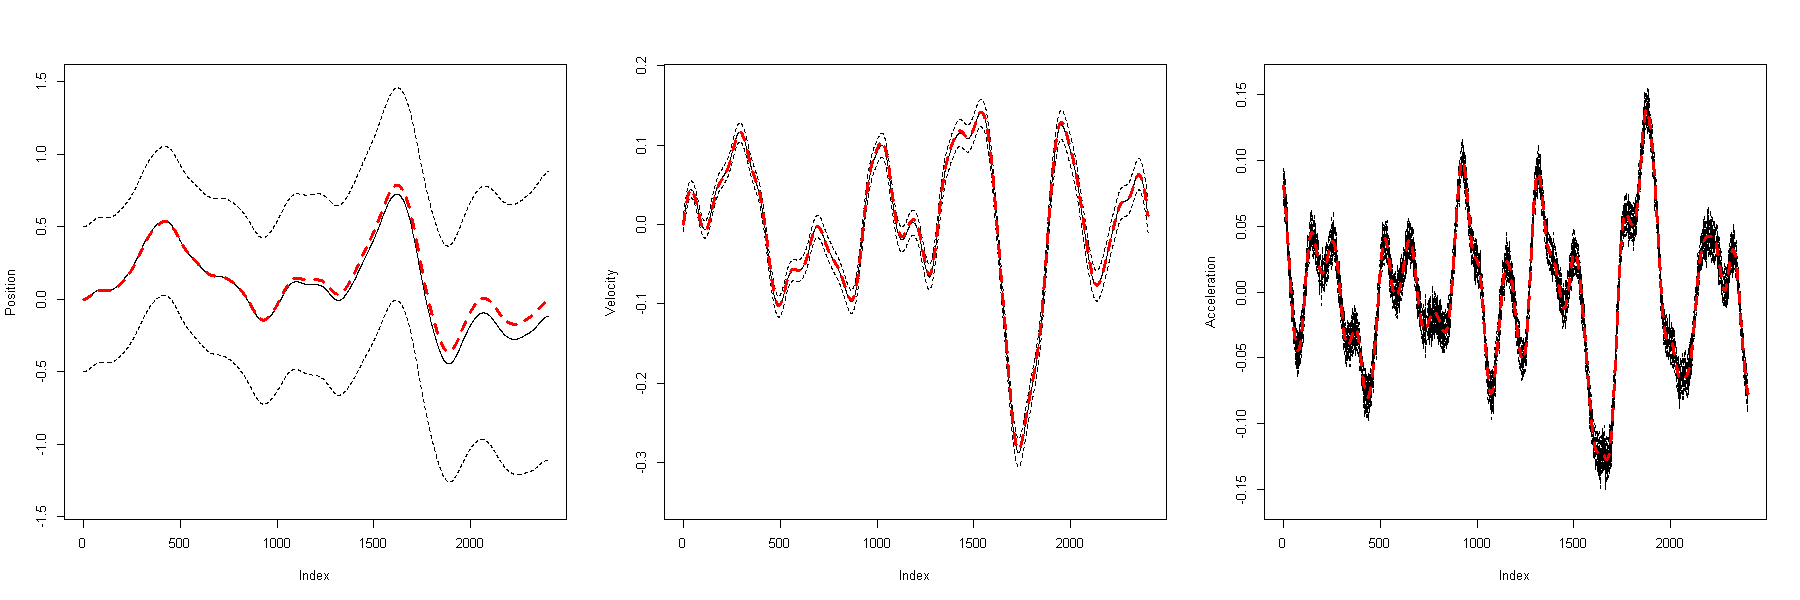

In [7]:
options(repr.plot.width = 15, repr.plot.height = 5)
par(mfrow=c(1,3))

plot(xf2[,1], type='l', lty=1, ylim=c(-1.4, 1.5), ylab="Position")
lines(xf2[,1] - 2*sqrt(varf2[,1]), lty=2)
lines(xf2[,1] + 2*sqrt(varf2[,1]), lty=2)
lines(x21, col='red', lty=2, lwd=3)

plot(xf2[,2], type='l', lty=1, ylim=c(-0.35, 0.18), ylab="Velocity")
lines(xf2[,2] - 2*sqrt(varf2[,2]), lty=2)
lines(xf2[,2] + 2*sqrt(varf2[,2]), lty=2)
lines(x22, col='red', lty=2, lwd=3)

plot(xf2[,3], type='l', lty=1, ylim=c(-0.16, 0.16), ylab="Acceleration")
lines(xf2[,3] - 2*sqrt(varf2[,3]), lty=2)
lines(xf2[,3] + 2*sqrt(varf2[,3]), lty=2)
lines(x23, col='red', lty=2, lwd=3)

## Forward filtering, backward sampling

In [8]:
set.seed(42)
collector = list()
for (i in 1:10){
    collector[[i]] = dlmBSample(outFilter2)
}

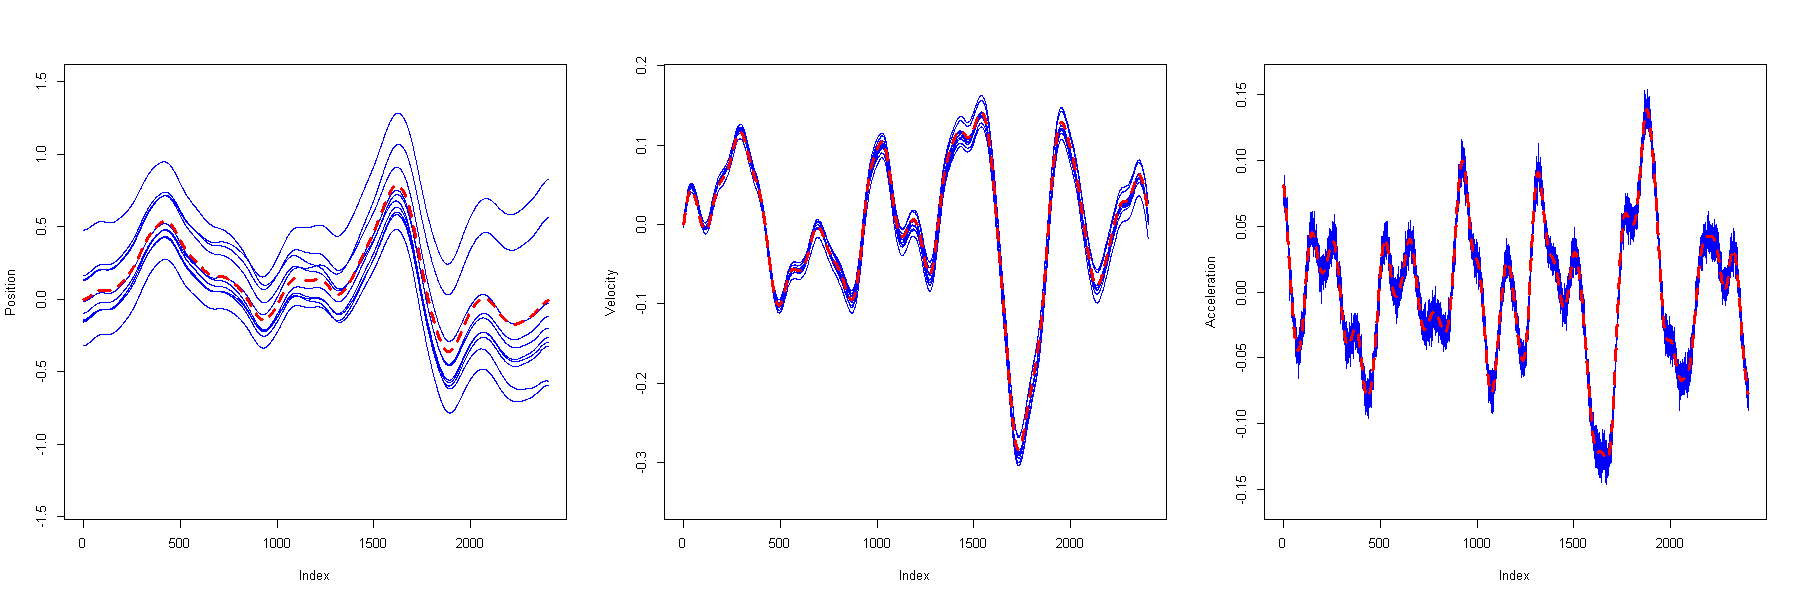

In [9]:
options(repr.plot.width = 15, repr.plot.height = 5)
par(mfrow=c(1,3))

plot(NULL,xlim=c(0,2400), ylim=c(-1.4, 1.5), ylab="Position")
for (i in 1:10){
    lines(collector[[i]][,1], col='blue')
}
lines(x21, col='red', lty=2, lwd=3)

plot(NULL,xlim=c(0,2400),  ylim=c(-0.35, 0.18), ylab="Velocity")
for (i in 1:10){
    lines(collector[[i]][,2], col='blue')
}
lines(x22, col='red', lty=2, lwd=3)

plot(NULL,xlim=c(0,2400),  ylim=c(-0.16, 0.16), ylab="Acceleration")
for (i in 1:10){
    lines(collector[[i]][,3], col='blue')
}
lines(x23, col='red', lty=2, lwd=3)

## Forward filtering, backward sampling meets Gibbs on paramaters

In [10]:
set.seed(42)
n_dig_samp=10
# NOTE: This function also samples the noise variance
dig_samp = dlmGibbsDIG(y=y2, mod=model, 
                       shape.y=1, rate.y=1, 
                       shape.theta=1, rate.theta=1, 
                       n.sample = n_dig_samp, 
                       save.states=TRUE)

xb_ffbs = array(dig_samp$theta, dim=c(2401, 3, n_dig_samp))
# plot(dig_samp$theta)
# for (i in 1:(3*10)){
#     abline(v=c(i*2401))
# }

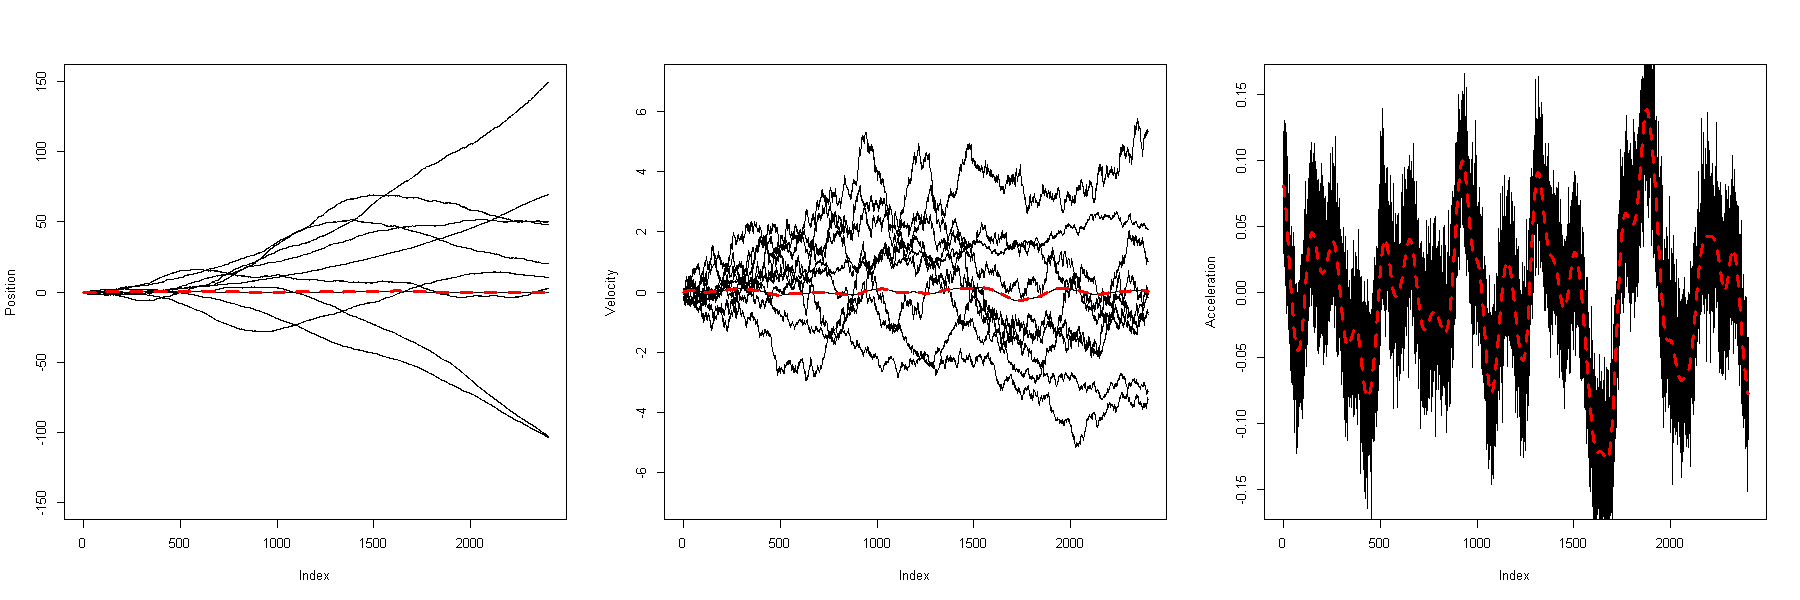

In [11]:
options(repr.plot.width = 15, repr.plot.height = 5)
par(mfrow=c(1,3))

plot(NULL,xlim=c(0,2400), ylim=c(-150, 150), ylab="Position")
for (i in 1:n_dig_samp)
    lines(xb_ffbs[-1,1,i])
lines(x21, lty=2, lwd=3, col='red')

plot(NULL,xlim=c(0,2400), ylim=c(-7, 7), ylab="Velocity")
for (i in 1:n_dig_samp)
    lines(xb_ffbs[-1,2,i])
lines(x22, lty=2, lwd=3, col='red')

plot(NULL,xlim=c(0,2400),ylim=c(-0.16, 0.16), ylab="Acceleration")
for (i in 1:n_dig_samp)
    lines(xb_ffbs[-1,3,i])
lines(x23,  lty=2, lwd=3, col='red')

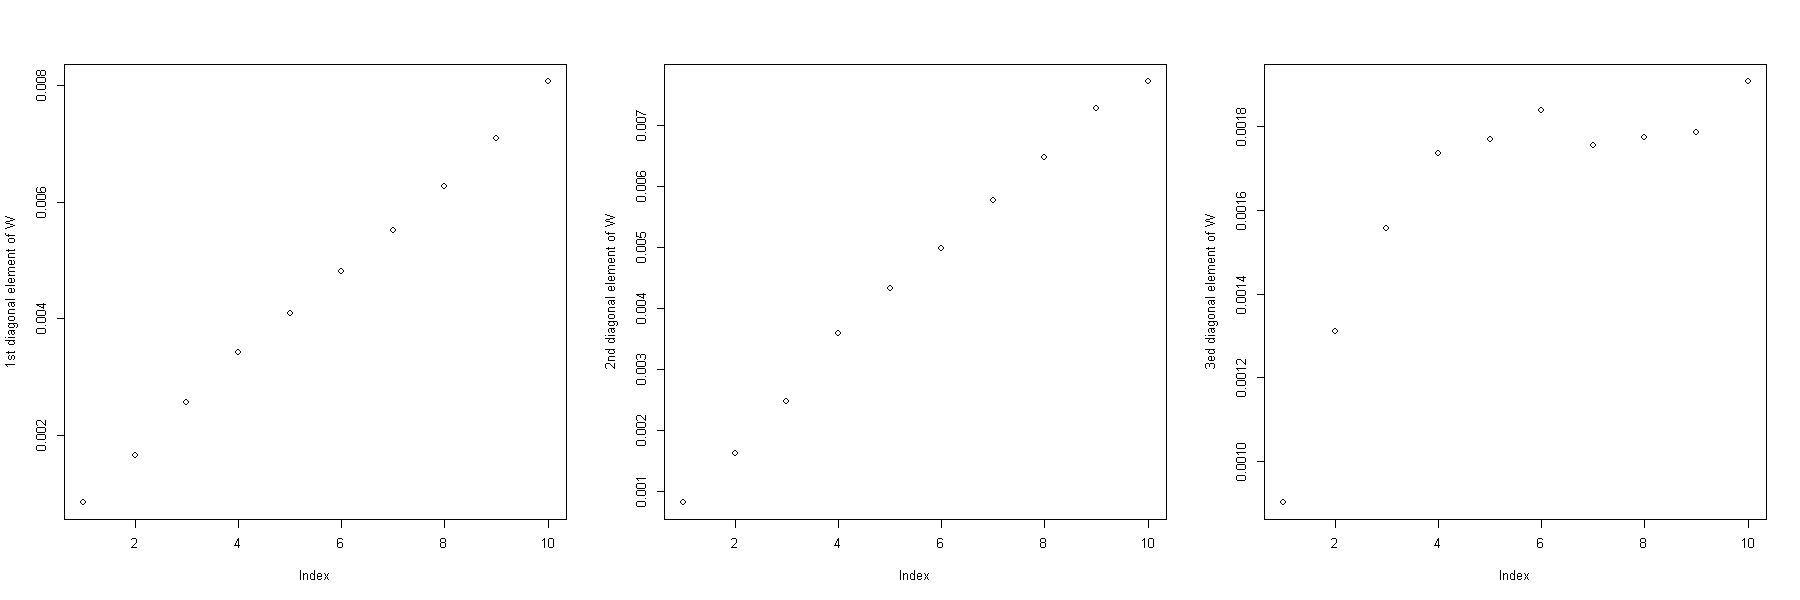

In [12]:
options(repr.plot.width = 15, repr.plot.height = 5)
par(mfrow=c(1,3))

plot(dig_samp$dW[,1], ylab="1st diagonal element of W")

plot(dig_samp$dW[,2], ylab="2nd diagonal element of W")

plot(dig_samp$dW[,3], ylab="3ed diagonal element of W")

[1] "True noise variance: 2.7333495917316e-05"


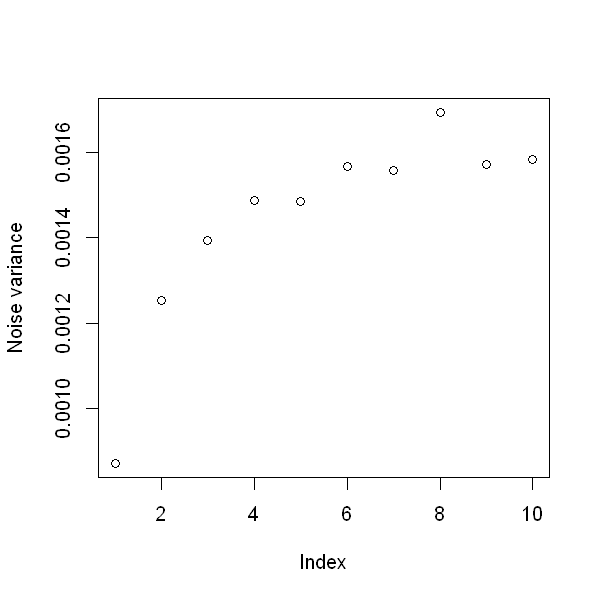

In [13]:
options(repr.plot.width = 5, repr.plot.height = 5)
plot(dig_samp$dV, ylab="Noise variance")
print(paste0("True noise variance: ", var_noise2))